<a href="https://colab.research.google.com/github/Simon-Pu/Temp/blob/master/rapids_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Sun Mar 22 02:26:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if device_name != b'Tesla T4' and device_name != b'Tesla P100-PCIE-16GB':
  raise Exception("""
    Unfortunately this instance does not have a T4 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

    If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print('Woo! You got the right kind of GPU!:::', device_name)

Woo! You got the right kind of GPU!::: b'Tesla T4'


#Setup:
Set up script installs
1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
1. removes incompatible files
1. Install RAPIDS libraries
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
1. If running v0.11 or higher, updates pyarrow library to 0.15.x.

In [3]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 49 (delta 10), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.
PLEASE READ
********************************************************************************************************
Colab Notebooks Migration Notice:
 
We have changed the location of the Colab script to our new CSP utilties repo.
We are also dropping support for versions below 0.11, as we are on 0.13 nightlies
 
Not all Colab notebooks are updated (like personal Colabs) and/or are using outdated versions of RAPIDS,
so we HIGHLY encourage users to update their scripts and Colab notebooks both with the new link AND with 
to the new API.  Otherwise, your code MAY BREAK
 
This notice will disappear/be updated on our next release.
 
Please enter in the box your desired RAPIDS version (ex: '0.11' or '0.12', between 0.11 t

# cuDF and cuML Examples #

Now you can run code! 

What follows are basic examples where all processing takes place on the GPU.

#[cuDF](https://github.com/rapidsai/cudf)#

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

_Note_: You must import nvstrings and nvcategory before cudf, else you'll get errors.

In [5]:
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
tips_df = cudf.read_csv(io.StringIO(content))
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

size
1    21.729202
2    16.571919
3    15.215685
4    14.594901
5    14.149549
6    15.622920
Name: tip_percentage, dtype: float64


#[cuML](https://github.com/rapidsai/cuml)#

This snippet loads a 

As above, all calculations are performed on the GPU.

In [6]:
import cuml

# Create and populate a GPU DataFrame
df_float = cudf.DataFrame()
df_float['0'] = [1.0, 2.0, 5.0]
df_float['1'] = [4.0, 2.0, 1.0]
df_float['2'] = [4.0, 2.0, 1.0]

# Setup and fit clusters
dbscan_float = cuml.DBSCAN(eps=1.0, min_samples=1)
dbscan_float.fit(df_float)

print(dbscan_float.labels_)

0    0
1    1
2    2
dtype: int32


In [7]:
# UMAP Supervised Demo (https://github.com/rapidsai/cuml/blob/branch-0.13/notebooks/umap_supervised_demo.ipynb)
# Fashion-MNIST dataset https://github.com/zalandoresearch/fashion-mnist
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!ls

--2020-03-22 02:52:12--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.194
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  87.9MB/s    in 0.3s    

2020-03-22 02:52:13 (87.9 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2020-03-22 02:52:15--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.194
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

In [11]:
import os
import pandas as pd
import numpy as np

# libraries for scoring/clustering
from sklearn.manifold.t_sne import trustworthiness

# GPU UMAP
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# Helper Functions
# Load The Data
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [0]:
#Training
train, train_labels = load_mnist('./', kind='train')
test, test_labels = load_mnist('./', kind='train')
data = (np.array(np.vstack([train, test]), dtype=np.float64) [:60000]/ 255.0).astype(np.float32)
target = np.array(np.hstack([train_labels, test_labels]))[:60000].astype(np.float32)

In [13]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"
train[0].shape

(784,)

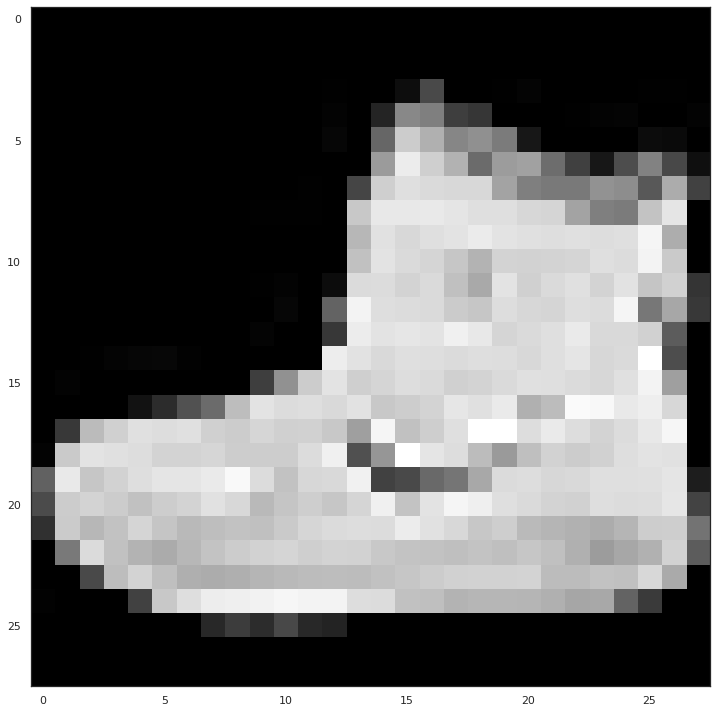

In [14]:
# display a Nike? sneaker
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')

In [15]:
%%time
record_data = (('fea%d'%i, data[:,i]) for i in range(data.shape[1]))
gdf = cudf.DataFrame()
for i in range(data.shape[1]):
    gdf['fea%d'%i] = data[:,i]

target_gdf = cudf.DataFrame()
target_gdf['fea0'] = target

CPU times: user 957 ms, sys: 25.7 ms, total: 983 ms
Wall time: 987 ms


In [16]:
import time
start = time.time()
g_embedding_supervised = cumlUMAP(verbose = False, n_neighbors=5, init="spectral", target_metric = "categorical").fit_transform(gdf, target_gdf)
print("Took %f sec." % (time.time() - start))

Took 9.821175 sec.


In [17]:
start = time.time()
g_embedding = cumlUMAP(n_neighbors=5, init="spectral").fit_transform(gdf)
print("Took %f sec." % (time.time() - start))

Took 6.091913 sec.


In [0]:
#Visualization
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

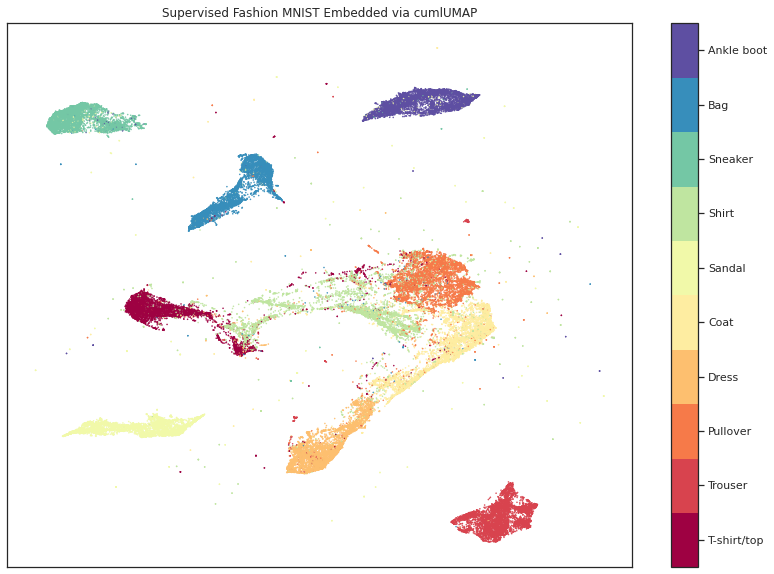

In [19]:
g_embedding_supervised_numpy = g_embedding_supervised.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(g_embedding_supervised_numpy[:,1], g_embedding_supervised_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Supervised Fashion MNIST Embedded via cumlUMAP');

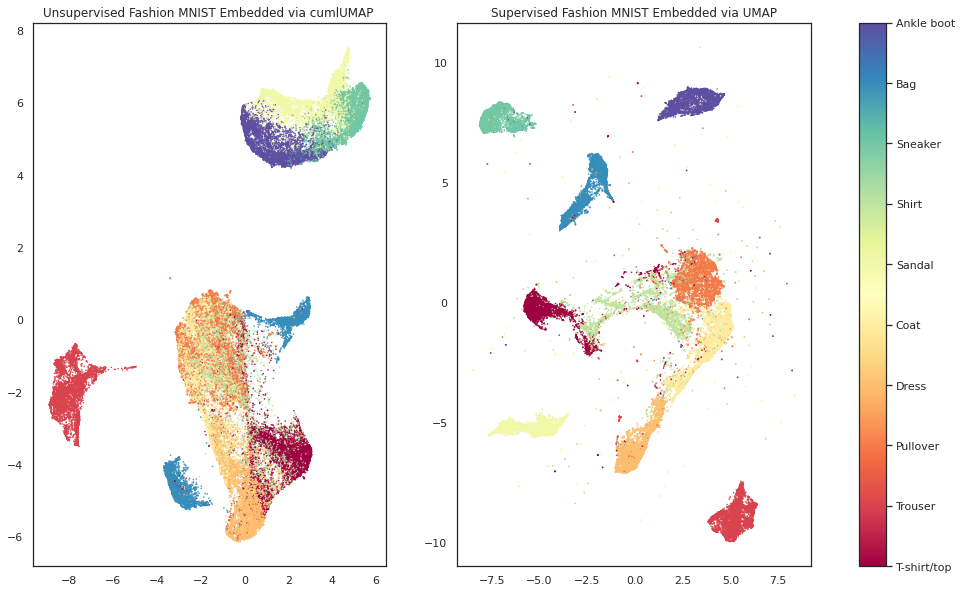

In [20]:
# Comparison of Implementations

g_embedding_numpy = g_embedding.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
im = ax[1].scatter(g_embedding_supervised_numpy[:,1], g_embedding_supervised_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)
ax[0].set_title('Unsupervised Fashion MNIST Embedded via cumlUMAP ');
ax[1].set_title('Supervised Fashion MNIST Embedded via UMAP');

fig.subplots_adjust(right=0.8)
cax,kw = mpl.colorbar.make_axes([a for a in ax.flat])
cbar = plt.colorbar(im, cax=cax, **kw)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

In [22]:
# TSNE Demo
# https://github.com/rapidsai/cuml/blob/branch-0.13/notebooks/tsne_demo.ipynb
# Reduce Dimensionality with TSNE
from cuml.manifold import TSNE

#Load data
train, train_labels = load_mnist('./', kind='train')
tsne = TSNE(n_components = 2, method = 'barnes_hut', random_state=23)
%time embedding = tsne.fit_transform(train)

print(embedding[:10], embedding.shape)

CPU times: user 2.66 s, sys: 2.14 s, total: 4.8 s
Wall time: 4.82 s
[[-19.479773 -17.188988]
 [ -4.908217  42.63339 ]
 [ 19.421942  35.405865]
 [ 16.08633   37.989338]
 [ 32.794273  59.477016]
 [ 16.618202   6.237122]
 [-21.061653  18.77913 ]
 [ 10.805793 -10.734965]
 [ -5.052463  -6.272669]
 [ -8.342087  -4.971858]] (60000, 2)


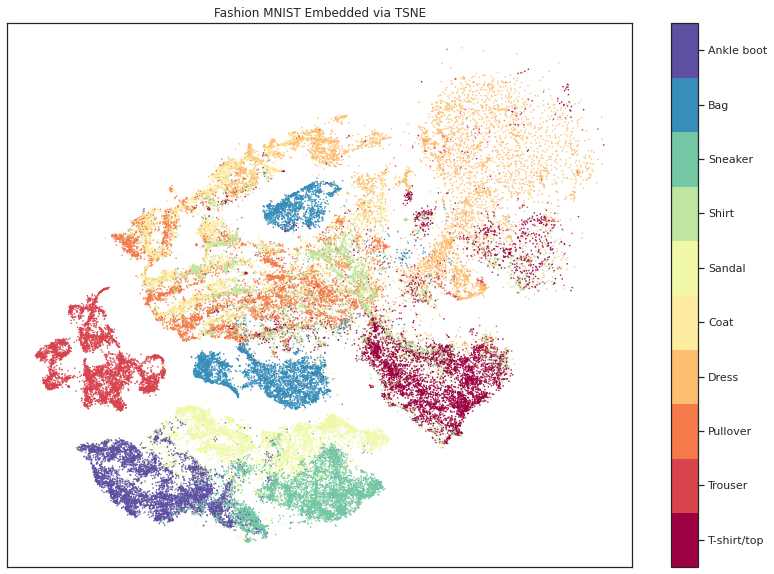

In [24]:
#Visualize Embedding
fig, ax = plt.subplots(1, figsize = (14, 10))
plt.scatter(embedding[:,1], embedding[:,0], s = 0.3, c = train_labels, cmap = 'Spectral')
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via TSNE');

# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib